# 분류분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다.

- cross_validate / AUC 계산
- 기본값으로 돌리면 90%나옴 - > 의미없음

In [401]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [10]:
df = pd.read_csv("./data/customer_churn.csv")

### 데이터 확인

In [11]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [12]:
df.shape

(900, 10)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


- 결측치 없음

In [14]:
df.dtypes

Names               object
Age                float64
Total_Purchase     float64
Account_Manager      int64
Years              float64
Num_Sites          float64
Onboard_date        object
Location            object
Company             object
Churn                int64
dtype: object

In [15]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


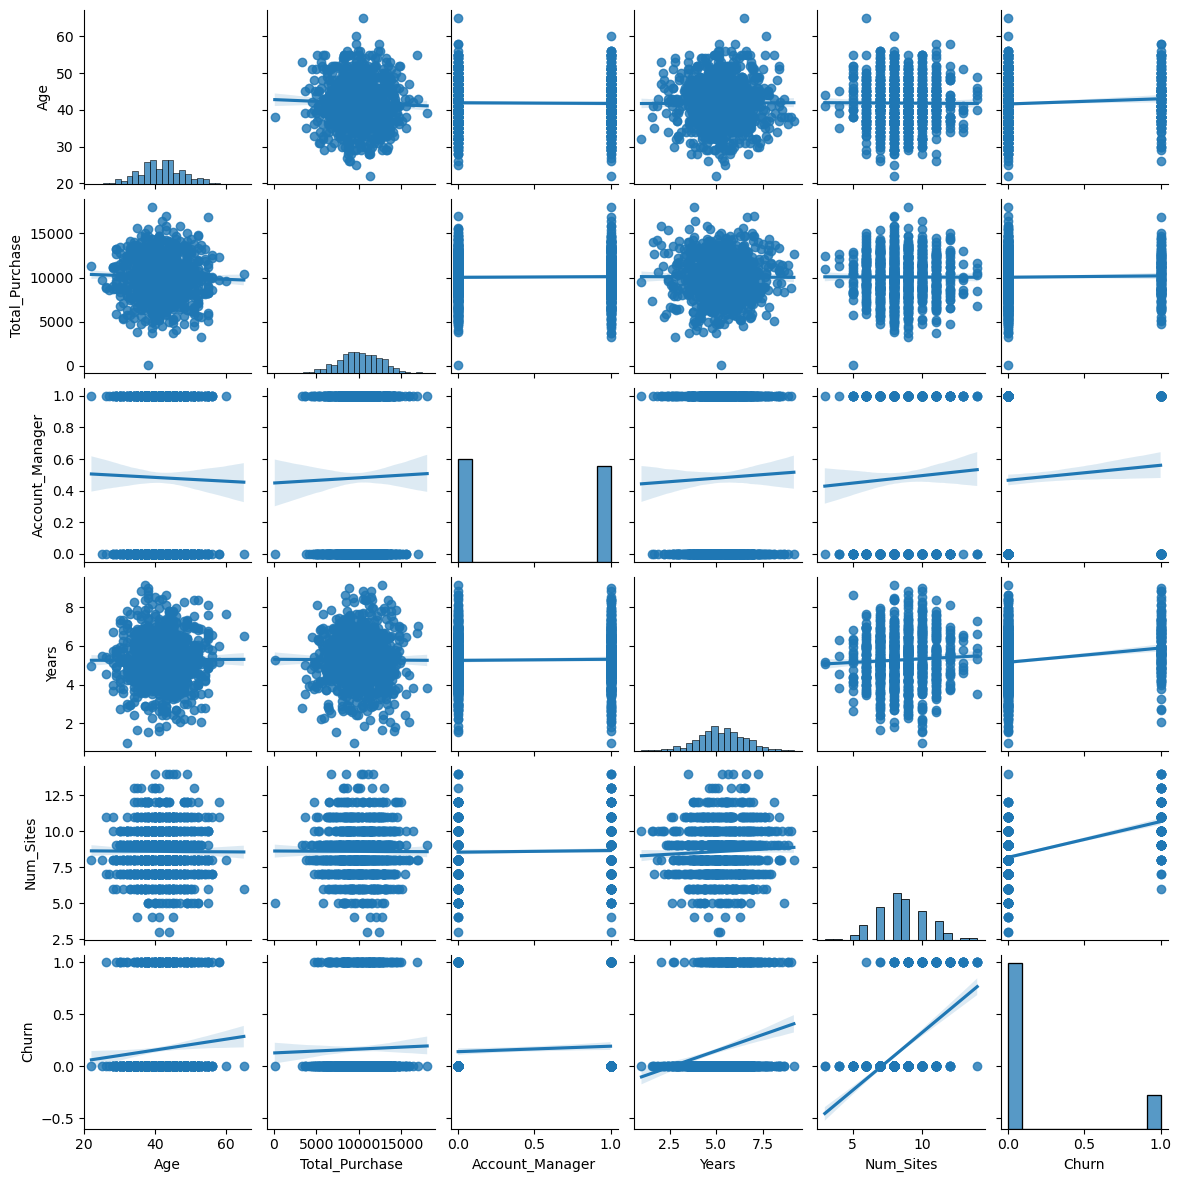

In [20]:
sns.pairplot(df.drop(["Names", "Location", "Company"],axis = 1), kind='reg', height = 2)

In [30]:
df_corr = df.drop(["Names", "Location", "Onboard_date", "Company"], axis = 1).corr()
df_corr

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
Age,1.000000,-0.037208,-0.014749,0.005625,-0.006070,0.085926
Total_Purchase,-0.037208,1.000000,0.015856,-0.005623,-0.003390,0.024031
Account_Manager,-0.014749,0.015856,1.000000,0.022930,0.033401,0.070611
Years,0.005625,-0.005623,0.022930,1.000000,0.051642,0.214329
Num_Sites,-0.006070,-0.003390,0.033401,0.051642,1.000000,0.525398
Churn,0.085926,0.024031,0.070611,0.214329,0.525398,1.000000


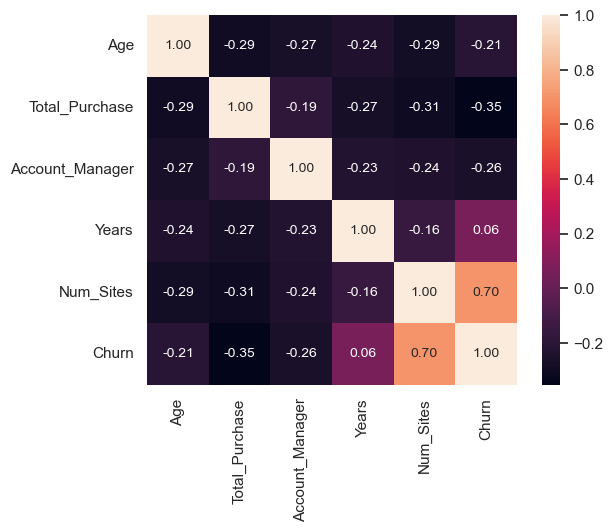

In [31]:
corr_mat = np.corrcoef(df_corr.values.T)
sns.set()
full_mat = sns.heatmap(corr_mat, cbar = True, annot = True, square = True, fmt = ".2f",
                      annot_kws = {"size" : 10}, yticklabels = df_corr,
                      xticklabels = df_corr)
plt.show()

- **Num_Sites 제외하고 필요한 컬럼을 볼 수 없음**

### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

In [33]:
df_new = df.drop(["Names","Onboard_date","Location","Company"],axis = 1)

- object 컬럼 제외

In [34]:
df_new.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1


#### 고객 이탈 여부를 y

In [35]:
x = df_new.drop("Churn", axis = 1)
y = df_new["Churn"]

In [337]:
# x = df_new.drop("Churn")
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.25, stratify = y, 
                                                 random_state = 4)

In [295]:
x1 = df_new[["Num_Sites", "Years"]]
y1 = df_new["Churn"]

In [370]:
# x1 = df_new[["Num_Sites", "Years"]]
x1_train,x1_test,y1_train,y1_test = train_test_split(x1, y1, test_size = 0.25, stratify = y, 
                                                 random_state = 4)

In [43]:
print(x_train.shape, x_test.shape)

(630, 5) (270, 5)


In [456]:
print(x1_train.shape, x1_test.shape)

(675, 2) (225, 2)


# 랜덤포레스트 

## 모델훈련

In [374]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 44)

In [453]:
# x = df_new.drop("Churn")
scores = cross_validate(rf, x_train, y_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.8971108705646028


In [454]:
# x1 = df_new[["Num_Sites", "Years"]]
rf = RandomForestClassifier(n_jobs = -1, random_state = 42)
scores = cross_validate(rf, x1_train, y1_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.8294528240132317


- (랜덤포레스트) x와 x1의 차이가 보임. x를 사용한 것이 더 높게 나옴

In [425]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [426]:
rf.feature_importances_

array([0.1445442 , 0.18409062, 0.03202088, 0.24022776, 0.39911654])

- "Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"
- "Num_Sites"의 중요도가 가장 높음을 확인할 수 있음

#### OOB 샘플

In [73]:
rf = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 1)
rf.fit(rf_x_train, rf_y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1)

In [57]:
rf.oob_score_

0.8666666666666667

In [58]:
# OOB 비율 계산
# 원본 데이터 세트의 크기
N = 1000

# 한 데이터 포인트가 한 번의 추출에서 선택되지 않을 확률
not_selected = 1 - 1/N

# N번의 추출 동안 단 한번도 선택되지 않을 확률
not_selected_N_times = not_selected ** N

# OOB 데이터 비율
not_selected_N_times

0.36769542477096373

# 엑스트라 트리

## 모델 훈련

In [451]:
# x = df_new.drop("Churn")
et = ExtraTreesClassifier(n_jobs = -1, random_state = 4)
scores = cross_validate(et, x_train, y_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.8835116091103972


In [452]:
# x1 = df_new[["Num_Sites", "Years"]]
et = ExtraTreesClassifier(n_jobs = -1, random_state = 4)
scores = cross_validate(et, x1_train, y1_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.7753309214832877


- (엑스트라트리) x와 x1을 사용했을 때 큰 차이가 보이는 것을 확인 할 수 있음. x를 사용한 것이 더 큼

In [429]:
et.fit(x_train, y_train)
print(et.feature_importances_)

[0.16291076 0.18283222 0.01597103 0.22255114 0.41573484]


- "Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"
- 엑스트라트리도 "Num_Sites"의 중요도가 가장 높음을 확인할 수 있음
- 랜덤포레스트보다 "Num_Sites"의 점수가 0.2 더 높음

# 그레디언트 부스팅

## 모델 훈련

In [448]:
# x = df_new.drop("Churn")
gb = GradientBoostingClassifier(random_state = 4)
scores = cross_validate(gb, x_train, y_train, scoring = "roc_auc", n_jobs = -1)
print(np.mean(scores["test_score"]))

0.8899929355946092


In [449]:
# x1 = df_new[["Num_Sites", "Years"]]
gb = GradientBoostingClassifier(random_state = 4)
scores = cross_validate(gb, x1_train, y1_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.8908854491987427


- (그레디언트 부스팅) x와 x1의 차이가 랜덤포레스트, 엑스트라 트리보다는 낮음. x1이 조금 높음

In [441]:
gb.fit(x_train, y_train)

GradientBoostingClassifier(random_state=4)

In [442]:
gb.feature_importances_

array([0.07860903, 0.12092591, 0.01588331, 0.22234865, 0.5622331 ])

- "Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"
- 그레디언트 부스팅도 "Num_Sites"의 중요도가 가장 높음을 확인할 수 있음
- "Num_Sites"의 점수가 0.56로 가장 높은 수치를 보임

# 로지스틱회귀

## 모델 훈련

In [446]:
lr = LogisticRegression()

In [450]:
# x = df_new.drop("Churn")
scores = cross_validate(lr, x_train, y_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.7692975694947608


In [404]:
# x1 = df_new[["Num_Sites", "Years"]]
scores = cross_validate(lr, x1_train, y1_train, scoring = "roc_auc")
print(np.mean(scores["test_score"]))

0.9018897752881978


- (로지스틱회귀) x와 x1의 큰 차이를 보임. x1이 더 높은 값이 나옴

In [405]:
lr.fit(x_train, y_train)

LogisticRegression(random_state=4)

# 결론_교차검증 AUC 값

- 랜덤포레스트와 엑스트라 트리의 경우 x와 x1 값 중 x를 사용한 값이 더 높게 나옴
- 그레디언트 부스팅과 로지스틱회귀의 경우 x와 x1 값 중 x1의 값이 더 크게 나옴

# new_customers 예측하기

In [109]:
new_c = pd.read_csv("./Data/new_customers.csv",index_col = False)

## 데이터 확인

In [111]:
new_c.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC


In [118]:
new_c.shape

(6, 9)

In [119]:
new_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            6 non-null      object 
 1   Age              6 non-null      float64
 2   Total_Purchase   6 non-null      float64
 3   Account_Manager  6 non-null      int64  
 4   Years            6 non-null      float64
 5   Num_Sites        6 non-null      float64
 6   Onboard_date     6 non-null      object 
 7   Location         6 non-null      object 
 8   Company          6 non-null      object 
dtypes: float64(4), int64(1), object(4)
memory usage: 564.0+ bytes


In [120]:
new_c.dtypes

Names               object
Age                float64
Total_Purchase     float64
Account_Manager      int64
Years              float64
Num_Sites          float64
Onboard_date        object
Location            object
Company             object
dtype: object

In [121]:
new_c.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,35.166667,7607.156667,0.833333,6.808333,12.333333
std,15.715173,4346.008233,0.408248,3.708738,3.386247
min,22.000000,100.000000,0.000000,1.000000,8.000000
25%,25.250000,6747.360000,1.000000,4.522500,9.500000
50%,32.000000,7986.100000,1.000000,8.495000,14.000000
75%,35.750000,9562.962500,1.000000,9.370000,14.750000
max,65.000000,13147.710000,1.000000,10.000000,15.000000


- 새로운 컬럼 지정

In [411]:
new_c_df = new_c[["Age","Total_Purchase","Account_Manager", "Years","Num_Sites"]]

In [412]:
new_c_df.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites
0,37.0,9935.53,1,7.71,8.0
1,23.0,7526.94,1,9.28,15.0
2,65.0,100.00,1,1.00,15.0
3,32.0,6487.50,0,9.40,14.0
4,32.0,13147.71,1,10.00,8.0


In [413]:
ss = StandardScaler()

In [414]:
scaled_new_c = ss.fit_transform(new_c_df)

## predict

In [209]:
rf_new_pred = rf.predict(new_c_df)
print(rf_new_pred)

[0 1 1 1 0 0]


In [210]:
et_new_pred = et.predict(new_c_df)
print(et_new_pred)

[0 1 0 1 0 0]


In [192]:
gb_new_pred = gb.predict(new_c_df)
print(gb_new_pred)

[0 0 1 0 0 0]


In [196]:
lr_new_pred = lr.predict(scaled_new_c)
print(lr_new_pred)

[0 1 1 1 0 1]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [416]:
predict = pd.DataFrame({'RandomForest' : rf_new_pred,
                       'Extratree' : et_new_pred,
                       'GradientBoostiong' : gb_new_pred,
                       'Logistic' : lr_new_pred})

## 결과

In [417]:
predict

,RandomForest,Extratree,GradientBoostiong,Logistic
0,0,0,0,0
1,1,1,0,1
2,1,0,1,1
3,1,1,0,1
4,0,0,0,0
5,0,0,0,1
